In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
api_key=os.environ.get("openrouter_api_key")

True

In [ ]:
from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(
#     model = "qwen/qwen3-30b-a3b:free", # "qwen/qwen3-14b:free", "qwen/qwen3-30b-a3b:free",
#     base_url="https://openrouter.ai/api/v1",
#     api_key=api_key,
#     )

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0,max_tokens=3000,) # "gemma2-9b-it", qwen-qwq-32b
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000215298FE720>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021519FFBC50>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'), max_tokens=3000)

In [114]:
from typing import Union, List
from langchain_ollama import OllamaEmbeddings
from langchain_elasticsearch import ElasticsearchStore, DenseVectorStrategy

def load_elastic_vectorstore(index_names: Union[str, List[str]]):
    # 단일 문자열인 경우 리스트로 변환
    if isinstance(index_names, str):
        index_names = [index_names]
    
    vector_store = ElasticsearchStore(
        index_name=index_names, 
        embedding=OllamaEmbeddings(
            base_url="http://localhost:11434", 
            model="bge-m3:latest"
        ), 
        es_url="http://localhost:9200",
        es_user="Kstyle",
        es_password="12345",
        # strategy=DenseVectorStrategy(hybrid=True)
    )
    return vector_store


index_names = ["ship_safety"]
vector_store = load_elastic_vectorstore(index_names=index_names)
vector_store

In [115]:
from FlagEmbedding import FlagReranker
reranking_model_path = "D:/LLMs/bge-reranker-v2-m3"
reranker = FlagReranker(model_name_or_path=reranking_model_path, 
                        use_fp16=True,
                        batch_size=512,
                        max_length=2048,
                        normalize=True)
reranker

In [116]:
import heapq

def reranking(query: str, docs: list, min_score: float = 0.5, top_k: int = 3):
# def reranking(state):
    """
    doc string
    """
    global reranker
    inputs = [[query, doc.page_content.lower()] for doc in docs]
    scores = reranker.compute_score(inputs)
    if not isinstance(scores, list):
        scores = [scores]

    print(f">>> original scores: {scores}")

    # Filter scores by threshold and keep index
    filtered_scores = [(score, idx) for idx, score in enumerate(scores) if score >= min_score]

    # Get top_k using heapq (more efficient than sorting full list)
    top_scores = heapq.nlargest(top_k, filtered_scores, key=lambda x: x[0])

    # Get document objects from top indices
    reranked_docs = [docs[idx] for _, idx in top_scores]

    return top_scores, reranked_docs


In [117]:
import operator
from typing import Annotated
from typing import Dict, TypedDict
from langgraph.graph.message import add_messages
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """
    context: Annotated[list, operator.add]
    keys: Dict[str, any]
    

In [118]:
from langchain_tavily import TavilySearch
from langchain.schema import Document

def web_agent(state: GraphState):
    
    """ Retrieve docs from web search """
    state_dict = state["keys"]

    # Search
    print("---Web Search---")
    tavily_search = TavilySearch(max_results=3)
    search_docs = tavily_search.invoke(state_dict['question'])
    print(f">>> Web 문서개수: {len(search_docs)}")
    contents = [f"{d['title']} \n {d['content']}" for d in search_docs['results']]
    metas = [d['url'] for d in search_docs['results']]

    docs_list = []
    for content, url in zip(contents, metas):
        docs_list.append(Document(page_content=content, metadata={'url':url}))

    # Reranking
    top_scores, documents = reranking(query=state_dict["question"], docs=docs_list, min_score = 0.5, top_k= 3)
    print(f">>> Web Reranking 문서개수: {len(documents)}")
    print(f">>> top_scores: {top_scores}")
    print(documents)   
    return {"context": documents} 

In [119]:
# inputs = {"keys": {'question': '2025년도 조선소 추락 사고 사례'}}
# result = web_agent(inputs)
# result 

In [120]:
def retrieve_agent(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, 
        that contains retrieved documents
    """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    retriever = vector_store.as_retriever(
        search_type="mmr", 
        search_kwargs={"fetch_k": 10, "k":5},
        )
    documents = retriever.invoke(state_dict["question"])
    print(f">>> Retrieve 문서개수: {len(documents)}")
    
    top_scores, documents = reranking(query=state_dict["question"], docs=documents, min_score = 0.5, top_k= 3)
    print(f">>> Retrieve Reranking 문서개수: {len(documents)}")
    print(f">>> top_scores: {top_scores}")
    print(documents)
    
    return {"context": documents}

In [121]:
# inputs = {"keys": {'question': '조선소 추락 사고 사례'}}
# result = retrieve_agent(inputs)
# result 

In [122]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def generate_agent(state: GraphState):
    print("---GENERATE---")

    state_dict = state["keys"]
    prompt = ChatPromptTemplate.from_messages([
    ("human", 
    """You are a Smart Safety Manager in Shipyard. 
    Use the following pieces of retrieved contexts or web search results to review and generate safety report.
    The final purpose of your report is to improve the safety level and lower any accident risks in the shipyard.
    Think step by step and generate logical and reasonable safety report in Korean Language.
    Nonetheless, If you don't know the answer, just say that you don't know. 
    Question: {messages} 
    Context: {context} 
    Answer:"""),
    ])

    rag_chain = prompt | llm | StrOutputParser()

    print(f">>> 합산문서개수: {len(state["context"])}")

    #Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # print(format_docs(state["context"]))
    
    # Static the Response
    generation = rag_chain.invoke({"context": format_docs(state["context"]), 
                                   "messages": state_dict['question']})
    return {"keys": {"generation": generation}}

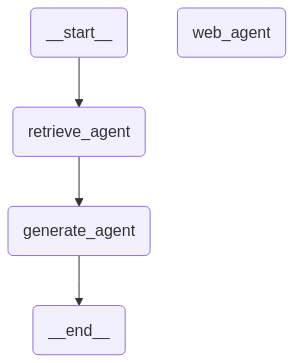

In [125]:
from langgraph.graph import StateGraph, START, END
def rag_builder(state):
    rag_builder = StateGraph(state)
    rag_builder.add_node("web_agent", web_agent)
    rag_builder.add_node("retrieve_agent", retrieve_agent)
    rag_builder.add_node("generate_agent", generate_agent)

    # rag_builder.add_edge(START, "web_agent")
    # rag_builder.add_edge("web_agent", "generate_agent")
    rag_builder.add_edge(START, "retrieve_agent") 
    rag_builder.add_edge("retrieve_agent", "generate_agent")
    rag_builder.add_edge("generate_agent", END)

    graph = rag_builder.compile()

    return graph

app = rag_builder(GraphState)
app

In [126]:
# Run
import pprint
inputs = {
    "keys": {
        "question": "중대재해의 정의 및 요건"
    }
}
for output in app.stream(inputs):
    # print(output)
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
# pprint.pprint(value['keys']['documents'])
pprint.pprint(value['keys']['generation'])

---RETRIEVE---
>>> Retrieve 문서개수: 5
>>> original scores: [0.864710137893859, 0.2235518598367174, 0.004967349823553644, 0.025638358316331378, 0.2536298336734885]
>>> Retrieve Reranking 문서개수: 1
>>> top_scores: [(0.864710137893859, 0)]
[Document(metadata={'filename': '안전보건 실무길잡이_선박건조 및 수리업.pdf', 'page': '32'}, page_content='This page explains 안전보건 실무길잡이_선박건조 및 수리업 that belongs to 안전 and  가이드 categories.\n<!-- image -->\n\n## Check Box\n\n## 용어의 정의\n\n- 사업주는 산업재해 조사표에 근로자 대표의 확인올 받아야 하여, 그 기재 내용에 대하여\n- 산업재해가 발생한 경우 다음 사항울 기록하고 3년간 보존한다.\n- 사업장의 개요 및 근로자의 인적사항, 재해 발생의 일시 및 장소 재해 발생의 원인 및 과정, 재해 재발방지 계획\n- 하는 경우 갈음활 수있음\n\n## 중대재해\n\n0 사망자가 1명 이상 발생한 재해   0 3개월 이상의 요양이 필요한 부상자가 동시에 2명 이상 발생한 재해 부상자 또는 직업성 질병자가 동시에 10명 이상 발생한 재해름 말한다.\n\n## 지체없이\n\n정당한 사유재해 등으로 인한 통신수단의 이용이 곤란하거나 재해자 응급구호; 2차 재해 재발방지루 위한 조치\n\n## 3일 이상의 휴업\n\n(휴업일수에 사고 발생일은 포함되지 않으나 법정공휴일 또는 근로 제공 의무가 없는 휴무일은 포함)\n\n## 작업중지 요건\n\n0 고용노동부장관은 . (중락).. 해당 사업장에 산재가 다시 발생할 급박한 위험이 있다고 판단 되는 경우 그 작업의 중지름 명할 수 있음\n\n- 중대재해가 발생한 해당 

In [79]:
# import time
# inputs = []
# results = []

In [80]:
# question = "중대재해의 정의"
# input = {'keys': {"role": "user", "question": question}}
# inputs.append(input["keys"])
# temp = []
# async for event in app.astream_events(input, version="v1"):
#     # print(event)
#     if event['event'] == 'on_chat_model_stream' or event['event'] == 'on_llm_stream':
#         try:
#             response = event['data']['chunk'].content    # groq, OpenRouter
#             temp.append(response)
#             print(response, end="")  
#             time.sleep(0.1)
#         except:
#             response = event['data']['chunk']   # ollama
#             temp.append(response)
#             print(response, end="")    
#             time.sleep(0.1)
#         finally: pass
        
#     else: pass
# total_res = "".join(temp[:])
# inputs.append({"role": "ai", "content": total_res})

In [81]:
# inputs

In [82]:
# question = "대한민국 고용노동부의 중대재해 예방 가이드에 대해 설명해주세요"
# input = {'keys': {"role": "user", "question": question}}
# inputs.append(input["keys"])
# temp = []
# async for event in app.astream_events(input, version="v1"):
#     # print(event)
#     if event['event'] == 'on_chat_model_stream' or event['event'] == 'on_llm_stream':
#         try:
#             response = event['data']['chunk'].content    # groq, OpenRouter
#             temp.append(response)
#             print(response, end="")  
#             time.sleep(0.1)
#         except:
#             response = event['data']['chunk']   # ollama
#             temp.append(response)
#             print(response, end="")    
#             time.sleep(0.1)
#         finally: pass
#     else: pass
# total_res = "".join(temp[:])
# inputs.append({"role": "ai", "content": total_res})

In [84]:
# inputs